# Foraging for Mushrooms in Random Forests
**A Machine Learning approach to binary classification of mushrooms as poisonous or edible**

Would you join me on a forage for wild mushrooms? When foraging for wild mushrooms, it's critical to accurately identify the species of mushroom you find to distinguish edible mushrooms from poisonous ones. 

There are some distinguishing features that indicate when a mushroom might be poisonous, such as:
- White gills
- Red cap or stem

However, traditional wisdom asserts that you must identify the species of any mushroom you eat. Relying on a few characteristics or other rules of thumb could be fatal! But is that traditional wisdom correct? Could we use Machine Learning to save us some time identifying mushrooms in the field so we can get on with our feast? Is it worth the risk? 

This notebook explores the UC Irvine Machine Learning Repository's [Mushroom Dataset](https://archive.ics.uci.edu/dataset/73/mushroom) as expanded by Kaggle in the [Binary Prediction of Poisonous Mushrooms](https://www.kaggle.com/competitions/playground-series-s4e8/data) Playground Series. 

*A notebook by Erik Anderson (eran6750@colorado.edu) for DTSA 5509 Intro to Machine Learning: Supervised Learning. Find the public repo on GitHub at https://github.com/eriktuck/death-cap-ml*

In [152]:
import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, roc_curve, auc

## Data Pre-processing
The Kaggle dataset has been generated using a deep learning model trained on the original data, and as such has data artifacts that must be cleaned prior to analysis. We'll see that categorical and boolean columns have values that are inconsistent with the original dataset, which has single-letter codes for each categorical column and 't' or 'f' for each boolean column. Any values that do not fit this paradigm will be replaced with `nan`. Boolean columns will be recast to `1` or `0`. Outliers in numerical column are defined as those with z-scores greater than 3. These records will be dropped.

In [153]:
data_path = os.path.join('data', 'train.csv')
data = pd.read_csv(data_path, index_col='id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 523.2+ MB


In [154]:
# Store columns by column type
numeric_cols = data.select_dtypes(include=['number']).columns
feature_cols = ['cap-shape', 'cap-surface', 'cap-color', 'gill-attachment', 
                'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 
                'stem-color', 'veil-type', 'veil-color', 'ring-type', 
                'spore-print-color', 'habitat', 'season']
bool_cols = ['does-bruise-or-bleed', 'has-ring']

In [155]:
# Reclass response variable
data['class'] = data['class'].map({'e': 0, 'p': 1})

### Class imbalance
There may be a class imbalance in our dataset. We want to avoid creating a model might bias towards either label simply because it is more prevalent. When splitting the training and testing data, fitting models and evaluating accuracy we'll pay close attention to this class imbalance, and our *very strong* preference for avoiding errors in any model that predicts whether a mushroom is poisonous.

In [156]:
print(f'Proportion of poisonous mushrooms in the data: {data['class'].mean():.2%}')

Proportion of poisonous mushrooms in the data: 54.71%


### Pre-process categorical and boolean columns
Let's explore the unique values in each categorical or boolean column to understand what types of data artifacts might have been created. From metadata provided with the original dataset, we know that these columns should only have single letter codes or 't' for True and 'f' for False. While the codes included in the synthetic data inlcude multiple that are not also present in the original dataset, we will leave any code that is a single letter code. 

In [157]:
# Print feature values
for column in data.columns:
    if data[column].dtype == 'object':
        print(f'{column}: {data[column].unique()}')

cap-shape: ['f' 'x' 'p' 'b' 'o' 'c' 's' 'd' 'e' 'n' nan 'w' 'k' 'l' '19.29' '5 f' 't'
 'g' 'z' 'a' '2.85' '7 x' 'r' 'u' '3.55' 'is s' 'y' '4.22' '3.6' '21.56'
 'i' '6 x' '24.16' '8' 'm' 'ring-type' '10.13' 'is p' '7.43' 'h' '0.82'
 '10.46' '2.77' '2.94' '12.62' '5.15' '19.04' '4.97' '49.21' 'b f' '9.13'
 '1.66' '3.37' '7.21' '3.25' '11.12' '3 x' '4.3' '7.41' '6.21' '8.29'
 '54.78' '20.25' '3.52' '3.04' '2.63' '3.91' '6.44' '8.3' '7.6' '17.44'
 '4.33' '2.82' '6.53' '19.06']
cap-surface: ['s' 'h' 'y' 'l' 't' 'e' 'g' nan 'd' 'i' 'w' 'k' '15.94' 'f' 'n' 'r' 'o'
 'a' 'u' 'z' '2.7' 'does l' '5.07' 'p' 'b' 'm' 'cap-diameter' '1.43' 'x'
 '7.14' 'c' 'is h' 'does t' '0.85' '6.57' '12.79' '6.45' '4.66' '23.18'
 '3.06' '16.39' '4.21' 'veil-color' '11.78' '8.1' 'has-ring' 'does h'
 '1.42' 'class' 'has h' 'does None' '10.83' 'season' '8.96' '14.04' '5.73'
 'is None' '24.38' '2.81' '0.88' '2.11' '2.79' 'ring-type'
 'does-bruise-or-bleed' '4.93' 'spore-print-color' 'spore-color' '2.92'
 '2.51' '7.99' 

In [158]:
# Define helper function to process categorical and boolean columns
def preprocess_data(data):
    for col in feature_cols:
        data[col] = data[col].where(data[col].isin(list(string.ascii_lowercase)), np.nan)

    for col in bool_cols:
        data[col] = data[col].where(data[col].isin(['f', 't']), np.nan)
        data[col] = data[col].map({'f': 0, 't': 1})

    return data

In [159]:
# Split the training and testing dataset
train, test = train_test_split(data, test_size=0.01, stratify=data['class'])  # , random_state=42
X_train = preprocess_data(train.drop(columns=['class']))
y_train = train['class']
X_test = preprocess_data(test.drop(columns=['class']))
y_test = test['class']
X_train = pd.DataFrame(X_train, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

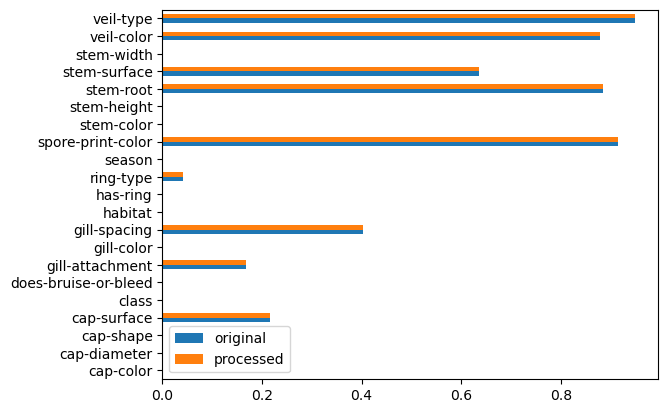

In [160]:
# Identify NaN values in provided data pre- and post-processing
original_na = data.iloc[X_train.index].isna().mean()
processed_na = X_train.isna().mean()
plot_data = pd.DataFrame({
    'original': original_na,
    'processed': processed_na
})
plot_data.plot(kind='barh');

From the plot above, we can see that post-processing we have only replaced a very few records that were likely to be artifacts from the data generation process. Let's inspect the values in these columns again.

In [161]:
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        print(f'{column}: {X_train[column].unique()}')

cap-shape: ['x' 'f' 's' 'b' 'o' 'c' 'p' 'n' nan 'e' 't' 'z' 'a' 'd' 'g' 'h' 'w' 'k'
 'l' 'y' 'u' 'm' 'i' 'r']
cap-surface: [nan 't' 's' 'y' 'd' 'g' 'i' 'h' 'k' 'e' 'w' 'l' 'x' 'm' 'a' 'f' 'p' 'n'
 'u' 'o' 'r' 'b' 'z' 'c']
cap-color: ['y' 'n' 'w' 'g' 'p' 'u' 'l' 'k' 'e' 'b' 'o' 'r' 'f' nan 'i' 't' 's' 'd'
 'h' 'x' 'c' 'a' 'm' 'z']
gill-attachment: ['s' 'a' 'x' 'd' nan 'f' 'p' 'e' 'k' 'b' 'i' 'g' 'y' 'c' 'n' 'o' 'l' 'w'
 't' 'u' 'h' 'm' 'r' 'z']
gill-spacing: ['d' nan 'c' 'f' 'p' 's' 'a' 'e' 'b' 'x' 'l' 'k' 'i' 't' 'h' 'y' 'g' 'r'
 'w' 'n']
gill-color: ['y' 'n' 'k' 'w' 'p' 'f' 'g' 'o' 'r' 'u' 'e' 'b' nan 'd' 'x' 'c' 't' 'z'
 'm' 'l' 'a' 's' 'h' 'i']
stem-root: [nan 'r' 'b' 's' 'c' 'f' 'm' 'y' 'p' 'd' 'a' 'l' 't' 'g' 'w' 'h' 'x' 'k'
 'o' 'e' 'z' 'i' 'n' 'u']
stem-surface: ['i' 'y' nan 's' 'h' 't' 'g' 'k' 'w' 'f' 'n' 'e' 'd' 'l' 'p' 'x' 'a' 'm'
 'r' 'c' 'o' 'b' 'u' 'z']
stem-color: ['y' 'n' 'w' 'p' 'o' 'g' 'e' 'u' 'r' 'l' 'k' 'b' 'f' nan 's' 'i' 'a' 'x'
 'm' 'h' 't' 'd' 'z' 'c']
veil-type:

### Remove outliers
Next we'll drop any outliers from the training data, using a z-score to exclude any values that are greater than 3 standard deviations from the mean.

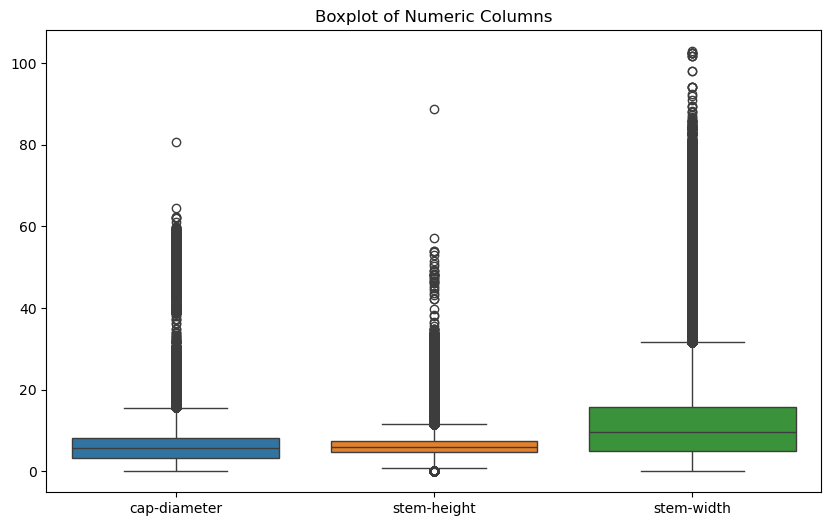

In [162]:
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[numeric_cols])
plt.title("Boxplot of Numeric Columns")
plt.show()

In [163]:
# Remove extreme values
z_scores = np.abs(zscore(X_train[numeric_cols], nan_policy='omit'))
non_outlier_indices = np.all(z_scores < 3, axis=1)
X_train = X_train[non_outlier_indices]
y_train = y_train[non_outlier_indices]

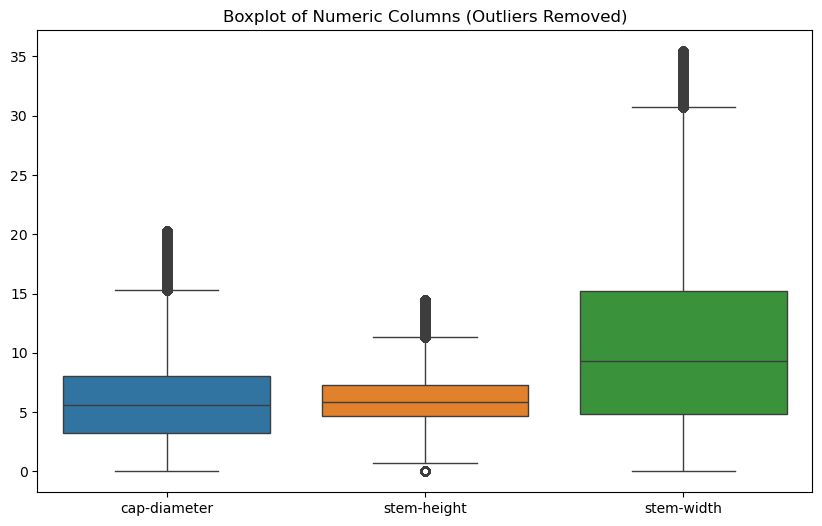

In [164]:
# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train[numeric_cols])
plt.title("Boxplot of Numeric Columns (Outliers Removed)")
plt.show()

From the plot above, we can see the values are now more constrained. Most of the dropped values are for observations with very large cap-diameter, stem-height or stem-width. To be safe, we should avoid any of these very large specimens we encounter in the field since our model might not generalize to such large mushrooms!

### Transformer Pipeline
Next, we'll prepare the data from various models using an Sci-Kit Learn pipeline. This pipeline prepares each column according to its data type. The pipeline incldes the following components
- Boolean columns
  - Imputes missing values using the most frequent value in the column
- Categorical columns
  - Imputes missing values using the most frequent value in the column
  - Converts categorical columns to multiple numeric columns using one-hot-encoding
- Numerical columns
  - Imputes missing values as the mean of the column
  - Scales all values so they have a mean of 0 and standard deviation of 1
  
To avoid data leakage from the training set to the test set, we will first fit the transformer to the training data and then apply it to the testing data.

While decision trees don't necessarily need numerical values to be scaled, other models like Logistic Regression do and so we'll take care of that now.

In [165]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Define preprocessing steps
boolean_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent'))
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

# Combine preprocessing for each column type
preprocessor = ColumnTransformer(transformers=[
    ('boolean', boolean_pipeline, bool_cols),
    ('categorical', categorical_pipeline, feature_cols),
    ('numeric', numeric_pipeline, numeric_cols)
])

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Because the dataset is very large (over 3 million records), I'll downsample the training data to make model fitting faster while exploring the process of model fitting. To re-run this workflow without downsampling, comment out the below cell.

In [ ]:
# # Downsample for expediency
# random_indices = np.random.choice(X_train.shape[0], size=10000, replace=False)
# X_train = X_train[random_indices]
# y_train = y_train.iloc[random_indices]

## First Model: Decision Tree
As a trained botanist, I'm used to identifying flora in the field with a dichotomous key. Dichotomous keys are a workflow for species identification that ask "yes" and "no" questions regarding characteristics of the plant to help eventually arrive at a species identification. That sounds like a Decision Tree to me! Let's see if we can produce a dichotomous key using Machine Learning by fitting a decision tree.

In [167]:
# Fit the decision tree
from sklearn import tree

clf = tree.DecisionTreeClassifier(class_weight="balanced")  # , random_state=42
clf = clf.fit(X_train, y_train)

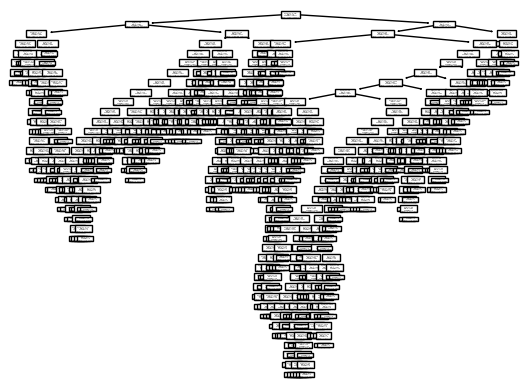

In [168]:
# Plot the decision tree
tree.plot_tree(clf);

In [169]:
# Helper function to retrieve feature names
def get_feature_names(preprocessor, boolean_cols, categorical_cols, numeric_cols):
    feature_names = []
    
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'boolean':  # Boolean columns
            feature_names.extend(boolean_cols)
        elif name == 'categorical':  # Categorical columns
            ohe = transformer.named_steps['onehot']
            feature_names.extend(ohe.get_feature_names_out(categorical_cols))
        elif name == 'numeric':  # Numeric columns
            feature_names.extend(numeric_cols)
    
    return feature_names

# Get feature names
feature_names = get_feature_names(preprocessor, bool_cols, feature_cols, numeric_cols)

In [170]:
# Print the tree
r = tree.export_text(clf, feature_names=feature_names)
print(r)

|--- stem-width <= -0.35
|   |--- gill-spacing_c <= 0.50
|   |   |--- stem-height <= -1.12
|   |   |   |--- cap-diameter <= -0.85
|   |   |   |   |--- gill-color_g <= 0.50
|   |   |   |   |   |--- stem-width <= -0.62
|   |   |   |   |   |   |--- habitat_d <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- habitat_d >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- stem-width >  -0.62
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- gill-color_g >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- cap-diameter >  -0.85
|   |   |   |   |--- cap-surface_s <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- cap-surface_s >  0.50
|   |   |   |   |   |--- stem-width <= -0.61
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- stem-width >  -0.61
|   |   |   |   |   |   |--- stem-width <= -0.60
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- stem-width >  -0.60
|   |   |   |   |  

The printed version of the tree above shows how the Decision Tree would be presented as a dichotomous key. There's a lot of questions in there! Should we trust it in the field? Let's look at the accuracy and confusion matrix to find out.

## Evaluating model accuracy
How should we think about accuracy in this context to pick a model that is most likely to prevent us from eating a poisonous mushroom? I would have a strong preference for avoiding poisonous mushrooms, even if it means I miss an opportunity to eat an edible look-alike. Thus, I'm operating under the precautionary principle. 

Recall that models suffer from Type I errors (false positives) and Type II errors (false negatives). A Type I error, when the model predicts "poisonous" when the mushroom is in fact edible may mean we miss out on trying that mushroom but is clearly less bad than the alternative. I'm more worried about false negatives, when the model predicts "edible" but the mushroom is in fact poisonous.  

When evaluating potential models, I want to focus on precision as a metric for selecting the best model. Precision measures the proportion of the mushrooms labeled "poisonous" that are in fact poisonous. 

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$

The higher the precision, the more likely that the model is actually capturing all poisonous mushrooms in the lable "poisonous".

The ROC curve plots the tradeoff between the rates of Type I and Type II errors. The higher the Area Under the Curve (ROC AUC), the better the model on both of these metrics. Thus, we'll use ROC AUC as well as precision to select the best model.

Test Precision: 0.96


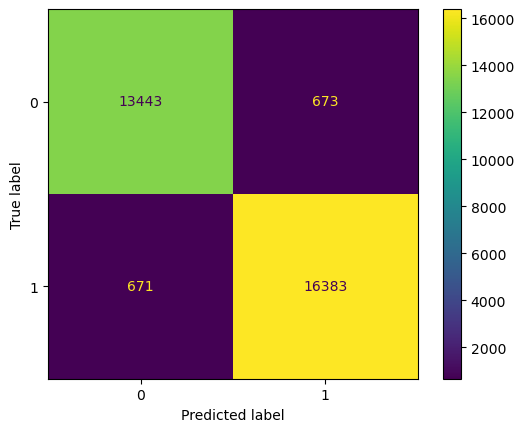

In [171]:
from sklearn.metrics import make_scorer
precision_scorer = make_scorer(precision_score, pos_label=1)

# Predict the labels for the test data
y_pred = clf.predict(X_test)

# Calculate precision
precision = precision_scorer(clf, X_test, y_test)
print(f"Test Precision: {precision:.2f}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

Our first tree has a pretty high accuracy. That sounds pretty good, but when we're wrong, we have a roughly a 50/50 chance of eating a poisonous mushroom we though was edible! 

## Pruning the Decision Tree
Decision trees are prone to overfitting. Tree pruning can be a useful approach to increasing test set accuracy by removing nodes from the tree that don't provide as much information. Sci-Kit Learn supports tree pruning using cost complexity pruning. I've adapted Sci-Kit Learn's [provided example](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py) for this dataset.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

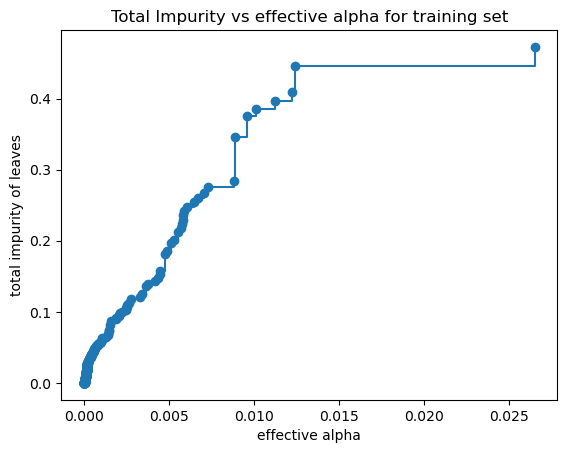

In [172]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [173]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(class_weight="balanced", 
                                      ccp_alpha=ccp_alpha)  # , random_state=42
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.027299848813096605


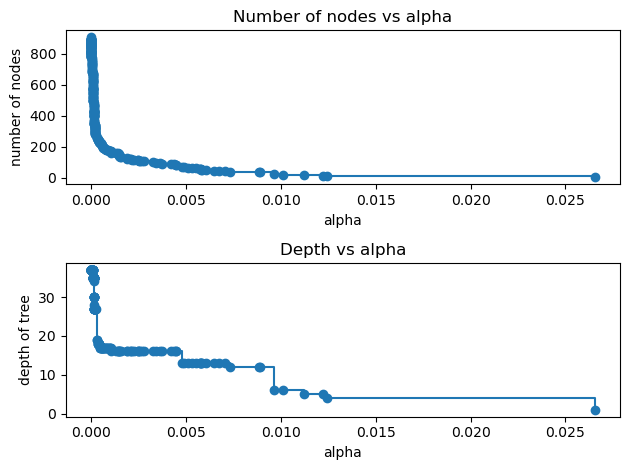

In [174]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

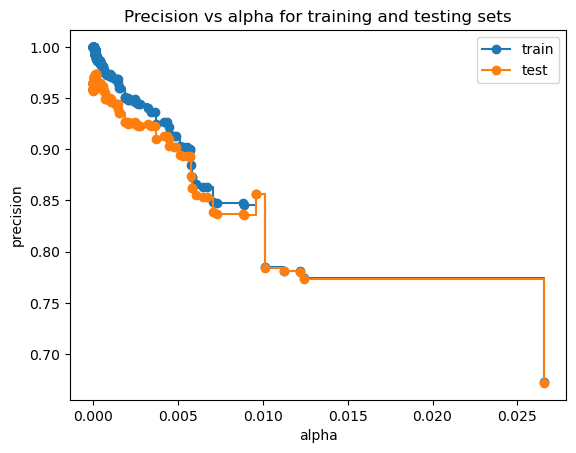

In [175]:
# Score all trees
train_scores = [precision_scorer(clf, X_train, y_train) for clf in clfs]
test_scores = [precision_scorer(clf, X_test, y_test) for clf in clfs]

# Plot results
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("precision")
ax.set_title("Precision vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

We can see that the precision for training and testing decreases nearly monotonically as alpha increases. The lower values of alpha have the highest precision. Let's zoom in to that region.

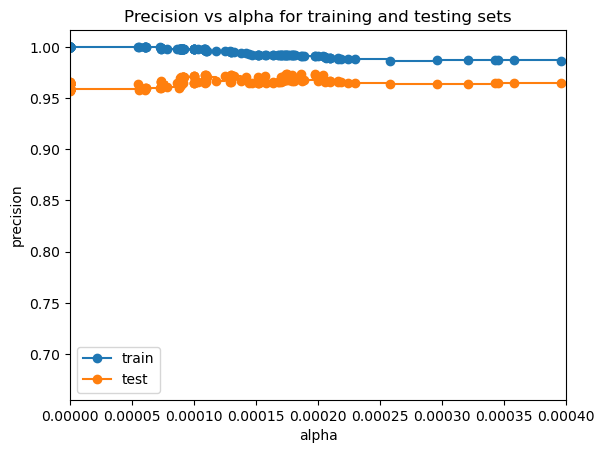

In [176]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("precision")
ax.set_title("Precision vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
plt.xlim(0, 0.0004)
ax.legend()
plt.show()

We can see that the testing set error is slightly below the training set error. For this dataset, the training precision is 100%, indicating some overfitting, while the testing precision has precision of 95% at `alpha=0`, increases slightly with more pruning,and then falls off. 

This behavior is not typical of the test set error, where one would expect a U-shape relating to the bias-variance tradeoff for the model. However, the relationship shown here is expected in a dataset with clear patterns, low noise, and strong feature-target relationships. In the original dataset (provided by UC Irvine rather than the deep learning-generated dataset) I was able to achieve 100% accuracy with a single tree of depth 8, suggesting that there is strong feature-target relationships between mushroom characteristics and their status as edible or poisonous. Thus, this result is not fully unexpected.

I've displayed the best tree below.

Best Tree has alpha: 0.00017 and max depth: 27


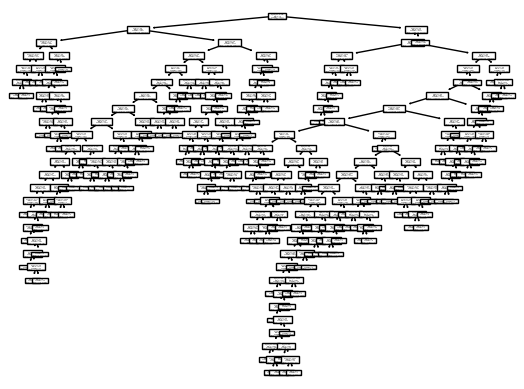

In [177]:
best_tree = clfs[test_scores.index(max(test_scores))]
print(f'Best Tree has alpha: {best_tree.ccp_alpha:.5f} and max depth: {best_tree.tree_.max_depth}')
tree.plot_tree(best_tree);

Test Precision: 0.97


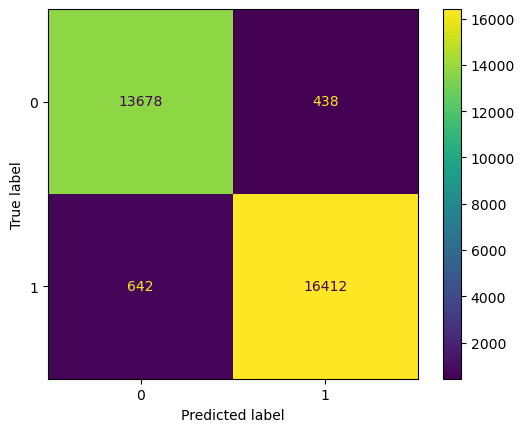

In [178]:
# Predict the labels for the test data
y_pred = best_tree.predict(X_test)

precision = precision_scorer(best_tree, X_test, y_test)
print(f"Test Precision: {precision:.2f}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

We didn't improve our accuracy too much from the unpruned tree because we didn't prune very much with such a low alpha.

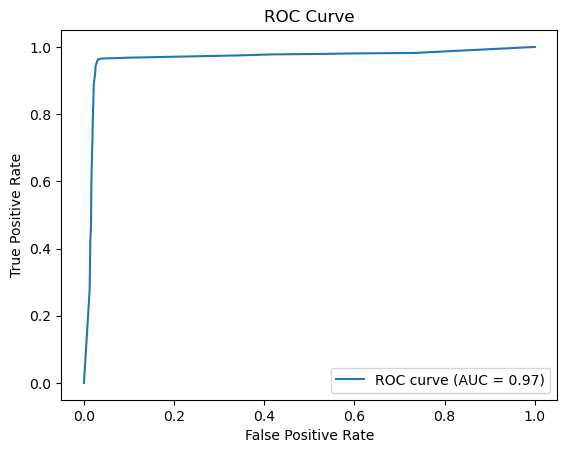

In [179]:
y_prob = best_tree.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Let's see if we can improve further with more advanced techniques than a single tree.

## Ensemble Methods: Random Forests
Random forests are an ensemble machine learning model that leverages bagging (bootstrap aggregation) to improve performance. As the name suggests, a forest is a collection of individual decision trees. Each tree is built from a sample drawn with replacement, referred to as a bootstrap sample. A different subset of features is used to build each tree to decorrelate the trees and further avoid overfitting.

In [180]:
from sklearn.ensemble import RandomForestClassifier

# Use the square root of total features for each tree
n_estimators = int(np.floor(np.sqrt(X_train.shape[0])))

# Fit random forest classifier
rf = RandomForestClassifier(n_estimators=n_estimators)
rf = rf.fit(X_train, y_train)

Let's investigate the accuracy and confusion matrix. Did the ensemble method help with precision?

Test Precision: 0.99


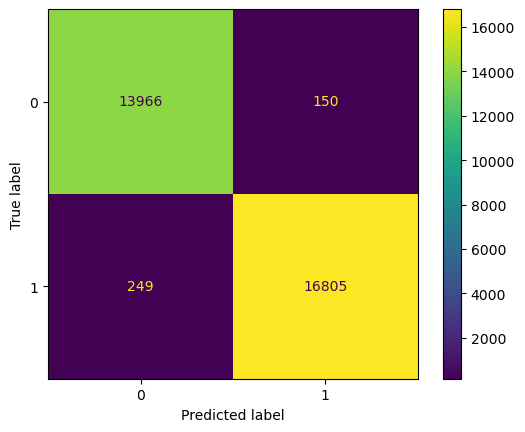

In [108]:
# Predict the labels for the test data
y_pred = rf.predict(X_test)

precision = precision_scorer(rf, X_test, y_test)
print(f"Test Precision: {precision:.2f}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

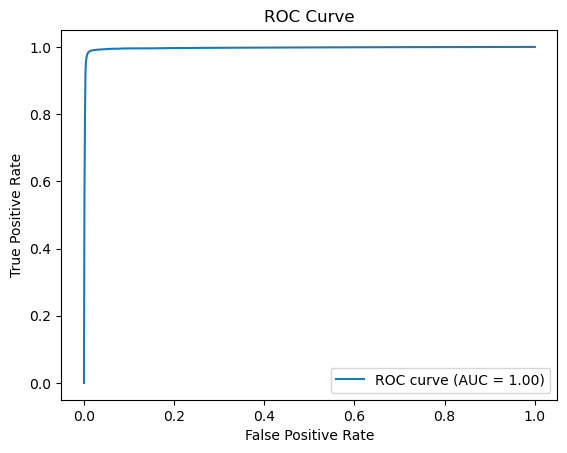

In [99]:
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Feature importances
Sci-Kit Learn provides a helpful utility for interograting feature importances. Understanding which features are the most important is helpful for model interpretation, explanation to stakeholders, and could be useful in developing other models that focus on the most important features.

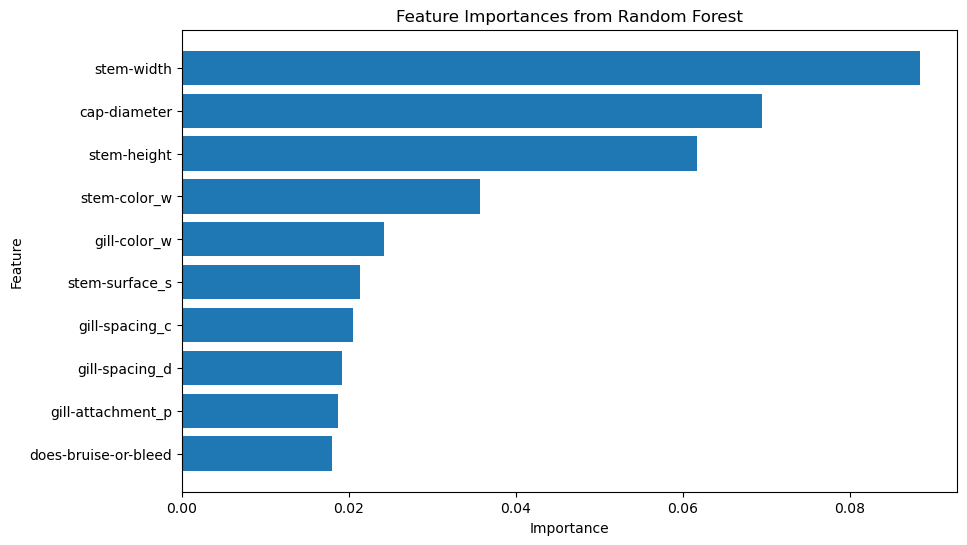

In [95]:
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'].head(10), importances['Importance'].head(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Flip the y-axis for descending order
plt.show()

## Ensemble Methods: Gradient Boosting
Gradient boosting is another ensemble method that uses boosting instead of bagging to improve performance. At each fit of the tree, the next tree is fit to minimize the loss function using gradient descent. Sci-kit Learn [recommends HistGradientBoostingCLassifier](https://scikit-learn.org/1.5/modules/ensemble.html#histogram-based-gradient-boosting), which is inspired by LightGBM.

In [110]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier(max_iter=100)
hgbc = hgbc.fit(X_train.toarray(), y_train)

Test Precision: 0.98


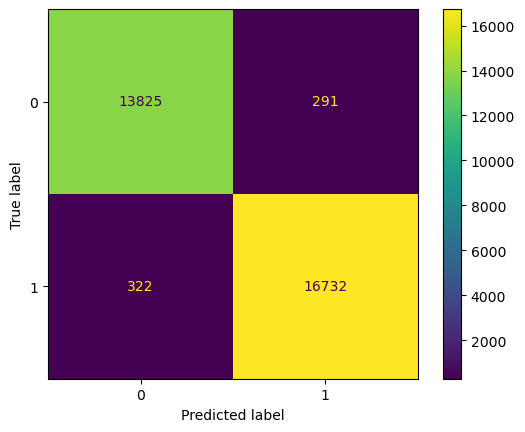

In [113]:
# Predict the labels for the test data
y_pred = hgbc.predict(X_test.toarray())

precision = precision_scorer(hgbc, X_test.toarray(), y_test)
print(f"Test Precision: {precision:.2f}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

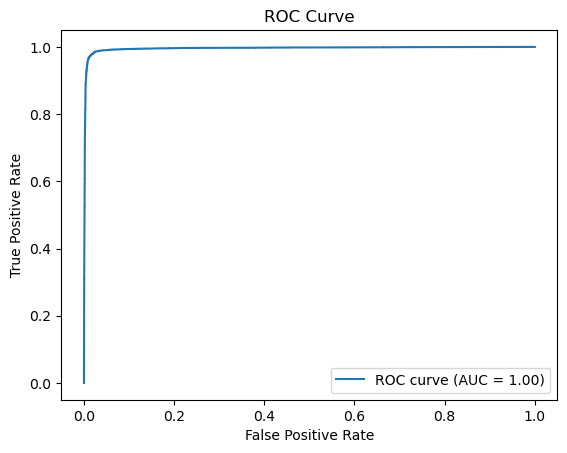

In [116]:
y_prob = hgbc.predict_proba(X_test.toarray())[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

For this dataset, we might not be surprised that gradient boosting does not improve upon random forests. Typically we would expect random forests to perform best on datasets with many features and gradient boosting to work best with fewer features. This dataset, once encoded, has 320 features. 

One advantage of the Histogram Based Gradient Boosting Classifier is that it is significantly faster than Random Forests to fit. For the purposes of this exploration, that allows us to tune a number of hyperparameters. We'll use the GridSearchCV utility to test different combinations of max iterations and learning rate to see if we can squeeze a bit more performance out of the model. Other hyperparameters to include in a more robust process include max leaf nodes, minimum samples per leaf, and L2 Regularization. 

In [122]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': [100, 200, 500],
    'learning_rate': [0.01, 0.1],
    # 'max_leaf_nodes': [31, 63, 127],
    # 'min_samples_leaf': [10, 20, 50],
    # 'l2_regularization': [0, 1, 10],
}

grid_search = GridSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    param_grid,
    scoring='precision',
    cv=3,
    n_jobs=-1,
    verbose=1,
)
grid_search.fit(X_train.toarray(), y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_iter': [100, 200, 500]},
             scoring='precision', verbose=1)

In [124]:
print(f"Best parameters: {grid_search.best_params_} have precision: {grid_search.best_score_:.2%}")

Best parameters: {'learning_rate': 0.1, 'max_iter': 200} have precision: 98.88%


Test Precision: 0.98


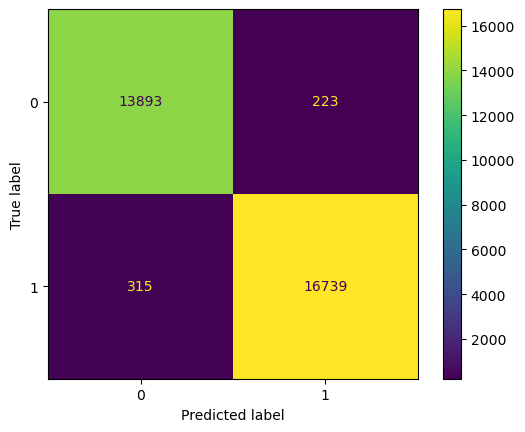

In [125]:
# Predict the labels for the test data
best_hgbc = grid_search.best_estimator_
y_pred = best_hgbc.predict(X_test.toarray())

precision = precision_scorer(hgbc, X_test.toarray(), y_test)
print(f"Test Precision: {precision:.2f}")

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot();

Indeed, we were able to get a few more classifications correct by using the tuned hyperparameters but still were not able to improve upon Random Forests. 

## Conclusion
This notebook demonstrates a supervised learning workflow. We used Decision Trees, Random Forests, and Histogram Based Gradient Boosting to predict the status of mushrooms as poisonous or edible using a playground dataset provided by Kaggle.

We evaluated models using precision to emphasize the importance of properly classifying poisonous mushrooms. With more time, continuing to tune hyperparameters and ensembling many models including Random Forests and boosted models would be reasonable next steps. We might also change the probability cutoff to further reduce the chances of classifying a poisonous mushroom as edible.

We were ultimately able to achieve a very high precision of 99%, however that might not be good enough depending on your risk tolerance! The safest bet when foraging for mushrooms is to positively identify every specimen to species before consuming. 

Happy hunting!

## Submission to Kaggle
To really put our model to the test, we'll predict on the test data and save out our submission. The Random Forest model scored 0.9747 while the top leaderboard position is 0.98514.

In [ ]:
# Read test data
test_path = os.path.join('data', 'test.csv')
test_df = pd.read_csv(test_path, index_col='id')
test_data = preprocess_data(test_df)
test_data = preprocessor.transform(test_data)

# Make predictions
predictions = rf.predict(test_data)

# Save as CSV
submission = pd.DataFrame(
    {'id': test_df.index,
    'class': predictions}
)
submission['class'] = submission['class'].map({0.0: 'e', 1.0: 'p'})
submission.set_index('id')
submission.to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,class
0,3116945,NaN
1,3116946,NaN
2,3116947,NaN
3,3116948,NaN
4,3116949,NaN
